In [12]:
import numpy as np
import sys,shutil
from pathlib import Path

import scipy.optimize as syopt
import scipy.special as sysp

import pandas as pd
import matplotlib.pyplot as plt



from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc
from time import time

# These imports needed for MCMC using Cobaya
from cobaya.yaml import yaml_load_file
from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya,MCSamples
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt






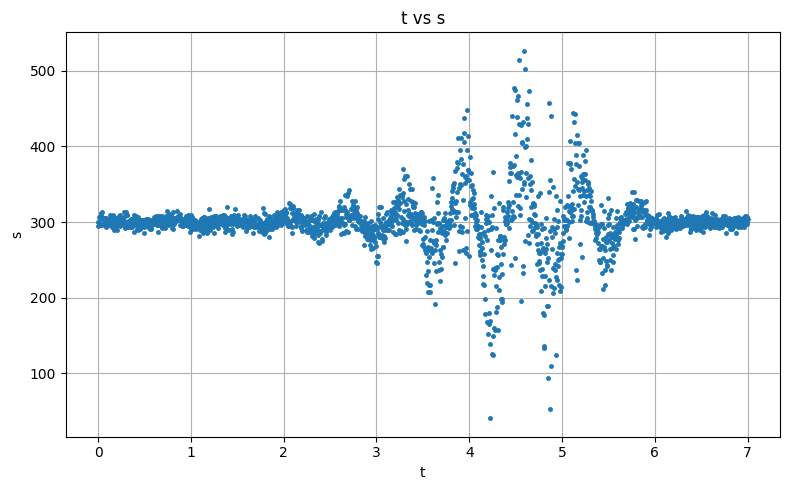

In [13]:


filename = 'flare_data.csv'  # change to your CSV path

# try with header, fall back to header=None if needed
try:
    df = pd.read_csv(filename)
    if df.shape[1] < 2:
        df = pd.read_csv(filename, header=None)
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {filename}")
except Exception:
    df = pd.read_csv(filename, header=None)

if df.shape[1] < 2:
    raise ValueError("CSV must contain at least two columns")

x = df.iloc[:, 0] 
y = df.iloc[:, 1] + 300
xlabel = str(df.columns[0])
ylabel = str(df.columns[1])

plt.figure(figsize=(8, 5))
plt.plot(x, y, 'o', markersize = 2.5 )
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(f"{xlabel} vs {ylabel}")
plt.grid(True)
plt.tight_layout()
plt.savefig("Data")
plt.show()


# MCMC

In [14]:

import likelihood

dim = 4

Run_Cobaya = True
Show_Cobaya = True
Resume = False

Max_Samples = 100000
Rminus1_Stop = 0.01 
Rminus1_CL_Stop = 0.05
Rminus1_CL_Level = 0.99
Burn_In = 0

Latex_List = []
Params_List = []
for m in range(dim):
    Latex_List.append('a_{'+str(m)+'}') 
    Params_List.append('a'+str(m))

print(Latex_List)
info = {}
info['likelihood'] = {'likelihood.ErrorLikelihood':
                      {'python_path':'./',
                       'data':y}}

info['theory'] = {'likelihood.FlareTheory':
                  {'python_path':'./',
                   'tvals':x}}

info['params'] = {}


info['params']['A'] = {
    'ref': 0.5,
    'prior': {'min': 0, 'max': 2},
    'proposal': 0.2,
    'latex': r'A'
}

info['params']['tau'] = {
    'ref': 5,
    'prior': {'min': 1, 'max': 10},
    'proposal': 0.1,
    'latex': r'\tau'
}

info['params']['omega'] = {
    'ref': 10,
    'prior': {'min': 1, 'max': 20},
    'proposal': 0.1,
    'latex': r'\omega'
}

info['params']['C'] = {
    'ref': 300,
    'prior': {'min': 1, 'max': 500},
    'proposal': 1,
    'latex': r'C'
}





info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 10000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}

info['output'] = 'stats/chains/Flare/poly_deg{0:d}'.format(dim-1)
if Resume:
    info["resume"] = True
else:
    info["force"] = True
print('... done with setup')


['a_{0}', 'a_{1}', 'a_{2}', 'a_{3}']
... done with setup


In [15]:
Run_Cobaya = True  # or False

if Run_Cobaya:
    start_time = time()
    
    updated_info, sampler = run(info)
    

[output] Output to be read-from/written-into folder 'stats/chains/Flare', with prefix 'poly_deg3'
[output] Found existing info files with the requested output prefix: 'stats/chains/Flare/poly_deg3'
[output] Will delete previous products ('force' was requested).
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: A:0.5, tau:5, omega:10, C:300
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {likelihood.ErrorLikelihood: 17200.0, likelihood.FlareTheory: 5260.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2026-01-06 11:30:25 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.024
[mcmc]  - Convergence of means: R-1 = 7.622640 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc]

# Trace Plots

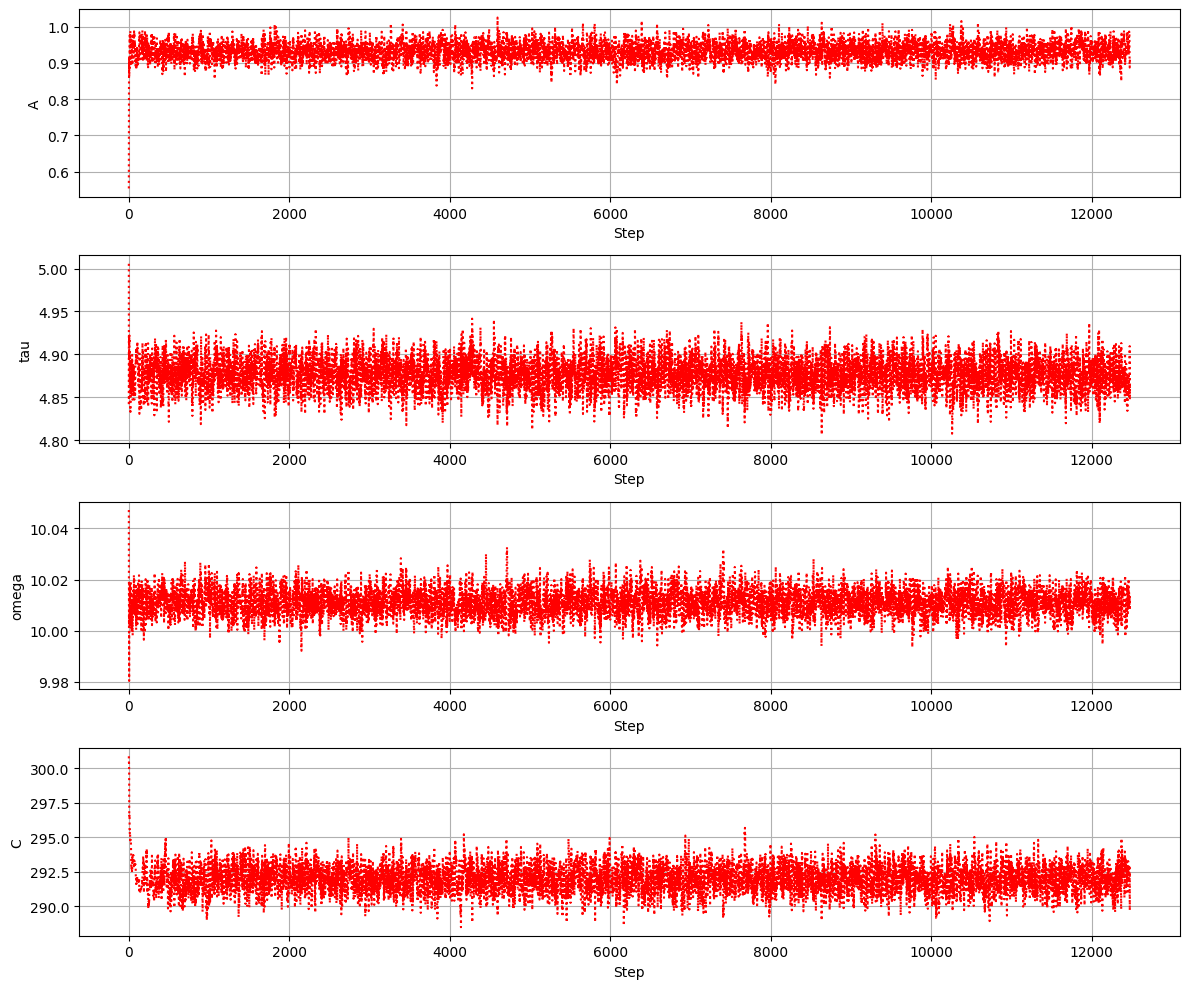

Last accepted parameter values:
A = 0.9027276
tau = 4.8645925
omega = 10.013496
C = 292.2217


In [16]:


# Load the chain file
filename = "stats/chains/Flare/poly_deg3.1.txt"  # adjust if needed

# Count header lines
with open(filename, 'r') as f:
    header_lines = 0
    for line in f:
        if line.startswith('#'):
            header_lines += 1
        else:
            break

# Load chain data
data = np.loadtxt(filename, skiprows=header_lines)

# Column index map for FLARE model
columns = {
    "weight": 0,
    "minuslogpost": 1,
    "A": 2,
    "tau": 3,
    "omega": 4,
    "C":5,
    "minuslogprior": 6
}

# Parameters to plot
params_text = ["A", "tau", "omega","C"]

# Trace plots
plt.figure(figsize=(12, 2.5 * len(params_text)))
for i, p in enumerate(params_text):
    plt.subplot(len(params_text), 1, i + 1)
    plt.plot(data[:, columns[p]], color="red", linestyle=":")
    plt.ylabel(p)
    plt.xlabel("Step")
    plt.grid(True)

plt.tight_layout()
plt.savefig("Trace plots")
plt.show()

# Print last accepted values
print("Last accepted parameter values:")
for p in params_text:
    print(f"{p} = {data[-1, columns[p]]}")




# Posterior Distributions / Histograms

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

Burn_In = 0.3
root = "stats/chains/Flare/poly_deg3"

gd_sample = loadMCSamples(root, settings={"ignore_rows": Burn_In})


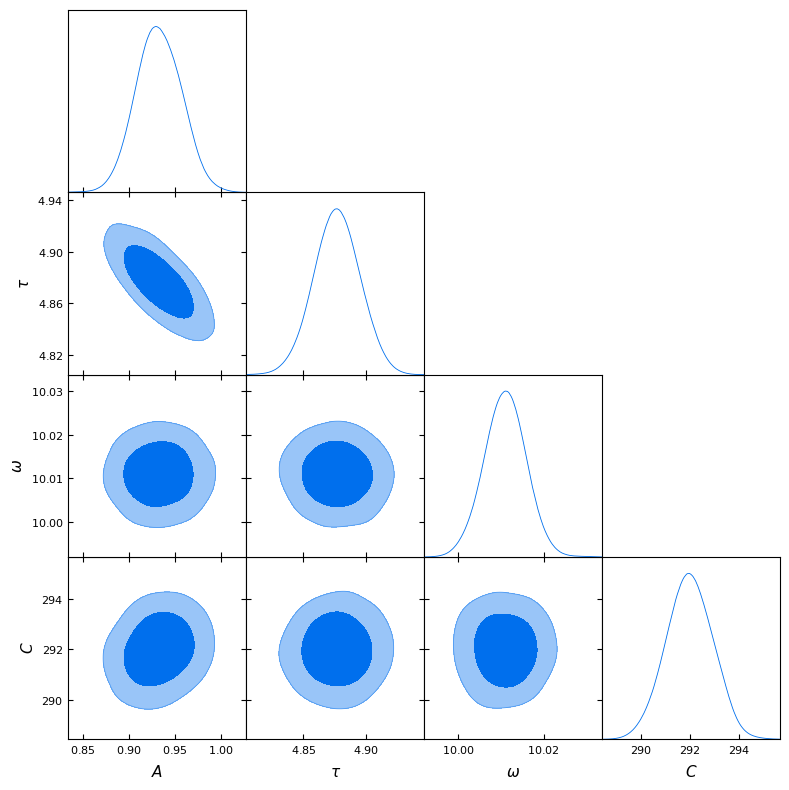

In [18]:
g = gdplt.get_subplot_plotter()
g.triangle_plot(
    gd_sample,
    ["A", "tau", "omega","C"],
    filled=True
)
plt.savefig("posterior")
plt.show()



# Best Fit

MCMC MAP parameters:
A     = 0.9292
tau   = 4.8768
omega = 10.0112
C = 291.9178


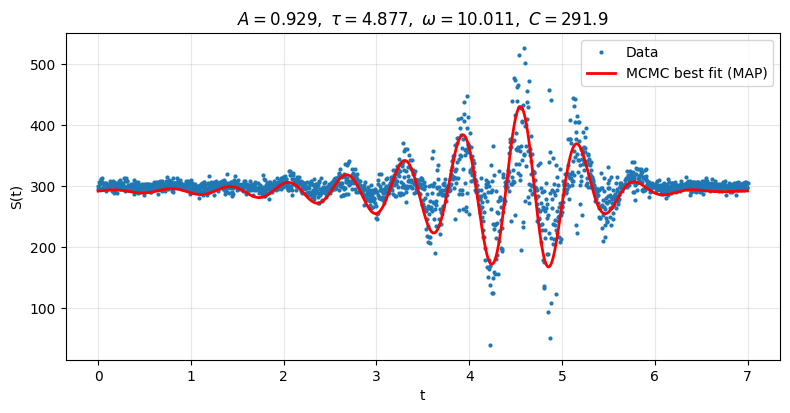

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Load MCMC chain
# -------------------------
Burn_In = 0.2
root = "stats/chains/Flare/poly_deg3"

chain = np.loadtxt(root + ".1.txt")
chain = chain[int(Burn_In * chain.shape[0]):]

# Columns:
# 0: weight
# 1: -logpost
# 2: A
# 3: tau
# 4: omega

minus_logpost = chain[:, 1]
ibest = np.argmin(minus_logpost)

A_map     = chain[ibest, 2]
tau_map   = chain[ibest, 3]
omega_map = chain[ibest, 4]
C_map = chain[ibest, 5]


print("MCMC MAP parameters:")
print(f"A     = {A_map:.4f}")
print(f"tau   = {tau_map:.4f}")
print(f"omega = {omega_map:.4f}")
print(f"C = {C_map:.4f}")


# -------------------------
# Flare model
# -------------------------
def flare_model(t, A, tau, omega, C):
    return (
        A
        * np.exp(t)
        * (1 - np.tanh(2 * (t - tau)))
        * np.sin(omega * t)
    ) + C

y_best = flare_model(x, A_map, tau_map, omega_map, C_map)

# -------------------------
# Plot: Data + MCMC best fit
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(x, y, 'o', ms=2, label='Data')
plt.plot(x, y_best, 'r-', lw=2, label='MCMC best fit (MAP)')
plt.xlabel('t')
plt.ylabel('S(t)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.title(
    rf"$A={A_map:.3f},\ \tau={tau_map:.3f},\ \omega={omega_map:.3f},\ C={C_map:.1f}$"
)
plt.savefig("best Fit")
plt.show()



# Comparison With True Data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

filename = 'flare_data.csv'  # change to your CSV path

# try with header, fall back to header=None if needed
try:
    df = pd.read_csv(filename)
    if df.shape[1] < 2:
        df = pd.read_csv(filename, header=None)
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {filename}")
except Exception:
    df = pd.read_csv(filename, header=None)

if df.shape[1] < 2:
    raise ValueError("CSV must contain at least two columns")

x = df.iloc[:, 0]
y = df.iloc[:, 1]
xlabel = str(df.columns[0])
ylabel = str(df.columns[1])

import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Interactive sliders for a 3-parameter model and live plotting

# Widgets: user will enter a lambda like: lambda x,a,b,c: a * np.sin(b * x + c)
func_text = widgets.Text(
    value="lambda t, A, omega, tau: A*np.exp(t) * (1-np.tanh(2*(t - tau))) *np.sin(omega*t)",
    description="f(x,a,b,c):",
    layout=widgets.Layout(width="70%")
)

a_slider = widgets.FloatSlider(value=1.0, min=0.0, max=2.0, step=0.001, description="A")
b_slider = widgets.FloatSlider(value=1.0, min=1.0, max=20.0, step=0.001, description="omega")
c_slider = widgets.FloatSlider(value=0.0, min=1.0, max=10.0, step=0.001, description="tau")

output = widgets.Output()

def update_plot(_=None):
    with output:
        clear_output(wait=True)
        try:
            f = eval(func_text.value, {"np": np})
            a, b, c = a_slider.value, b_slider.value, c_slider.value
            xv = np.asarray(x)  # uses x from the notebook
            y_model = f(xv, a, b, c)

            fig, ax = plt.subplots(figsize=(8, 5))
            ax.plot(x, y, marker='o', linestyle='', ms=4, label='data')  # uses y from the notebook
            ax.plot(x, y_model, color='red', label='model')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title("Data and model")
            ax.grid(True)
            ax.legend()
            display(fig)
            plt.close(fig)
        except Exception as e:
            print("Error evaluating/plotting function:", e)

# Wire up events
func_text.on_submit(update_plot)
for w in (a_slider, b_slider, c_slider):
    w.observe(update_plot, names='value')

# Display controls and initial plot
controls = widgets.HBox([a_slider, b_slider, c_slider])
display(widgets.VBox([func_text, controls, output]))
update_plot()

/tmp/ipykernel_5850/2765024511.py:66: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  func_text.on_submit(update_plot)
